In [38]:
import os
import glob
import time
import json
import numpy as np
import pandas as pd
import pickle
from multiprocessing.pool import Pool
from collections import defaultdict
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from scipy.sparse import csr_matrix
from scipy.interpolate import NearestNDInterpolator
from scipy.spatial import Voronoi, distance_matrix
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
import cc3d
from skimage.morphology import ball as morphology_ball
from skimage.morphology import cube as morphology_cube
from skimage.morphology import erosion
from skimage.filters.rank import median as rank_median_filter

import leidenalg as lg
import igraph as ig

import sys
# sys.path.append('/Users/krystal/Softwares/installation/pylib/anatomy/anatomy_vis.py')

from image_utils import get_mip_image, image_histeq
from file_io import load_image, save_image
from anatomy.anatomy_config import MASK_CCF25_FILE, MASK_CCF25_R314_FILE, REGION314, REGION671, SALIENT_REGIONS
from anatomy.anatomy_vis import detect_edges2d
from math_utils import min_distances_between_two_sets
from anatomy.anatomy_vis import get_brain_outline2d, get_section_boundary_with_outline, get_brain_mask2d, get_section_boundary

# import sys
# sys.path.append("/Users/krystal/Desktop/project/pylib-main")

sys.path.append('/Users/krystal/Desktop/project/Brain_test/BrainParcellation/common_lib')
from configs import __FEAT_NAMES__, __FEAT_ALL__

sys.path.append('/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron')
from shape_normalize import shape_normalized_scaling
from generate_me_map import process_mip

In [5]:
def load_features(mefile, scale=25., feat_type='full', flipLR=True):
    df = pd.read_csv(mefile, index_col=0, comment='#')
    
    if feat_type == 'full':
        cols = df.columns
        fnames = [fname for fname in cols if fname[-3:] == '_me']
    elif feat_type == 'mRMR':
        # Features selected by mRMR
        fnames = ['Length_me', 'AverageFragmentation_me', 'AverageContraction_me']
    elif feat_type == 'PCA':
        fnames = ['pca_feat1', 'pca_feat2', 'pca_feat3']
    else:
        raise ValueError("Unsupported feature types")

    # standardize
    tmp = df[fnames]
    tmp = (tmp - tmp.mean()) / (tmp.std() + 1e-10)
    df[fnames] = tmp

    # scaling the coordinates to CCFv3-25um space
    df['soma_x'] /= scale
    df['soma_y'] /= scale
    df['soma_z'] /= scale
    # we should remove the out-of-region coordinates
    zdim,ydim,xdim = (456,320,528)   # dimensions for CCFv3-25um atlas
    in_region = (df['soma_x'] >= 0) & (df['soma_x'] < xdim) & \
                (df['soma_y'] >= 0) & (df['soma_y'] < ydim) & \
                (df['soma_z'] >= 0) & (df['soma_z'] < zdim)
    df = df[in_region]
    print(f'Filtered out {in_region.shape[0] - df.shape[0]}')

    if flipLR:
        # mirror right hemispheric points to left hemisphere
        zdim2 = zdim // 2
        nzi = np.nonzero(df['soma_z'] < zdim2)
        loci = df.index[nzi]
        df.loc[loci, 'soma_z'] = zdim - df.loc[loci, 'soma_z']

    return df, fnames

In [6]:
mefile = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/data/mefeatures_100K_with_PCAfeatures3.csv'
df,fnames = load_features(mefile, scale=25)

Filtered out 0


In [10]:
regid = 733
min_pts_per_parc = 8**3

cp_mask = df['region_id_r671'] == regid
coords_all = df[['soma_x', 'soma_y', 'soma_z']]
coords = coords_all[cp_mask]
coords_int = np.floor(coords).astype('int')
feats_all = df[fnames].to_numpy()
feats = feats_all[cp_mask]

mask_file = MASK_CCF25_FILE
mask = load_image(mask_file) 
lmask = mask.copy() 
lmask[:mask.shape[0]//2] = 0
reg_mask = lmask == regid

nzcoords = reg_mask.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
zmin, ymin, xmin = nzcoords_t.min(axis=0)
zmax, ymax, xmax = nzcoords_t.max(axis=0)
reg_sub_mask = reg_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]


radius_th = 4.  # 4x25=100um
par2 = 3.

coords = coords.values.astype(np.float64)
n_neighbors = min(150, coords.shape[0])
coords_t = shape_normalized_scaling(reg_mask, coords, visualize=False)

Scales are: [2.21012253 3.01614897 4.6298914 ]


In [11]:
A = kneighbors_graph(coords_t, 
                        n_neighbors=n_neighbors, include_self=True, 
                        mode='distance', metric='euclidean', n_jobs=2)
dist_th = A[A>0].max()# + 1e-5   # to ensure all included

#A = radius_neighbors_graph(coords, radius=dist_th, include_self=True, mode='distance', metric='euclidean', n_jobs=n_jobs)
A.setdiag(0)

A_csr = csr_matrix(A)
sources, targets = A_csr.nonzero()
# estimate the edge weights
dists = A_csr[sources, targets]

In [12]:
wd = np.squeeze(np.asarray(np.exp(-dists/dist_th)))
print(f'wd[mean/max/min]: {wd.mean():.2f}, {wd.max():.2f}, {wd.min():.2f}')
print(f'Total and avg number of edges: {wd.shape[0]}, {wd.shape[0]/feats.shape[0]:.2f}')

wd[mean/max/min]: 0.75, 0.99, 0.37
Total and avg number of edges: 108472, 149.00


In [13]:
fs = feats[sources]
ft = feats[targets]
par2 = par2 / 3.
wf = np.exp(-par2 * np.linalg.norm(fs - ft, axis=1))
print(f'wf[mean/max/min]: {wf.mean():.2f}, {wf.max():.2f}, {wf.min():.2g}')

wf[mean/max/min]: 0.02, 0.97, 2.6e-08


In [14]:
#weights = wd * wf
weights = wf


g = ig.Graph(list(zip(sources, targets)), directed=False)
g.es['weight'] = weights

### Step 3: Apply the Leiden Algorithm
partition = lg.find_partition(g, lg.ModularityVertexPartition, weights='weight', seed=1024)

cm = [i for i in partition.membership]
nii = max(partition.membership)
for ii in range(len(cm), coords.shape[0]):
    nii += 1
    cm.append(nii)

community_memberships = np.array([i+1 for i in cm]) # re-indexing starting from 1, to differentiate with background

# denoising at the neuron level
# remove nodes with nearest nodes are not the same class
topk = 6
A1 = kneighbors_graph(coords_t, n_neighbors=topk-1, include_self=False, mode='distance', metric='euclidean')
yc, xc = A1.nonzero()
Ab = community_memberships[xc].reshape(-1, topk-1)
Ab = np.hstack((community_memberships.reshape(-1,1), Ab))
community_memberships = np.array([np.bincount(row).argmax() for row in Ab])


community_sizes = np.array([len(community) for community in partition])
comms, counts = np.unique(community_sizes, return_counts=True)
communities = defaultdict(list) # community to node

# Populate the dictionary with node indices grouped by their community
for node_index, community_index in enumerate(community_memberships):
    communities[community_index].append(node_index)

In [57]:
import matplotlib.cm as cm
def random_colorize(coords, values, shape3d, color_level):
    """
    coords in shape of [N,3], in order of ZYX
    """
    # map the communities to different colors using randomized color map
    norm = mpl.colors.Normalize(values.min(), vmax=values.max())
    vals = np.linspace(0,1,color_level)
    np.random.shuffle(vals)
    cmap = cm.colors.ListedColormap(cm.rainbow(vals))
    #cmap = cm.bwr
    smapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = np.floor(smapper.to_rgba(values) * 255).astype(np.uint8)
    zyx = np.floor(coords).astype(np.int32)

    # intialize map
    pmap = np.zeros((*shape3d, colors.shape[-1]), dtype=np.uint8)
    pmap[zyx[:,0], zyx[:,1], zyx[:,2]] = colors

    return pmap

def visualize_on_ccf(dfp, mask, prefix='temp'):
    shape3d = mask.shape
    zdim2, ydim2, xdim2 = shape3d[0]//2, shape3d[1]//2, shape3d[2]//2

    crds = dfp[['soma_z', 'soma_y', 'soma_x']]
    values = dfp['parc']
    ncolors = values.max()
    pmap = random_colorize(crds.to_numpy(), values, shape3d, ncolors)
    
    thickX2 = 10
    axid = 2
    for isec, sec in enumerate(range(thickX2, shape3d[axid], thickX2*2)):
        print(f'--> Processing section: {sec}')
        cur_map = pmap.copy()
        cur_map[:,:,:isec*2*thickX2] = 0
        cur_map[:,:,(isec*2+2)*thickX2:] = 0
        print(cur_map.mean(), cur_map.std())

        mip = get_mip_image(cur_map, axid)
        figname = 'cluster.png'
        process_mip(mip, mask, axis=axid, figname=figname, mode='composite', sectionX=sec, with_outline=False, pt_scale=5, b_scale=0.5)
        # load and remove the zero-alpha block
        img = cv2.imread(figname, cv2.IMREAD_UNCHANGED)
        wnz = np.nonzero(img[img.shape[0]//2,:,-1])[0]
        ws, we = wnz[0], wnz[-1]
        hnz = np.nonzero(img[:,img.shape[1]//2,-1])[0]
        hs, he = hnz[0], hnz[-1]
        img = img[hs:he+1, ws:we+1]
        if axid != 0:   # rotate 90
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        # set the alpha of non-brain region as 0
        img[img[:,:,-1] == 1] = 0
        img = img[:,::-1]
        cv2.imwrite(figname, img)

In [16]:
dfp = df[cp_mask].copy()
dfp['parc'] = community_memberships

In [36]:
def plot_section_outline(mask, axis=0, sectionX=None, ax=None, with_outline=True, outline_color='orange', b_scale=0.5):
    boundary_mask2d = get_section_boundary(mask, axis=axis, v=1, c=sectionX)
    sh, sw = boundary_mask2d.shape[:2]
    if ax is None:
        fig, ax = plt.subplots()
        brain_mask2d = get_brain_mask2d(mask, axis=axis, v=1)
        im = np.ones((sh, sw, 4), dtype=np.uint8) * 255
        im[~brain_mask2d] = 0#1

    # show boundary
    b_indices = np.where(boundary_mask2d)
    ax.scatter(b_indices[1], b_indices[0], s=b_scale, c='black', alpha=0.5, edgecolors='none')
    # intra-brain regions
        
    if with_outline:
        outline_mask2d = get_brain_outline2d(mask, axis=axis, v=1)
        o_indices = np.where(outline_mask2d)
        ax.scatter(o_indices[1], o_indices[0], s=1.0, c=outline_color, alpha=1.0, edgecolors='none')
    
    if ax is None:
        return fig, ax
    else:
        return ax

In [18]:
final_ccf_path = '/Users/krystal/Desktop/project/pylib-main/anatomy/resources/annotation_25.nrrd'
ccf_mask = load_image(final_ccf_path)
ccf_lmask = ccf_mask.copy()
ccf_lmask[:ccf_mask.shape[0]//2] = 0
target_mask = ccf_lmask == 733

In [51]:
crds = dfp[['soma_z', 'soma_y', 'soma_x']]
values = dfp['parc']
color_level = values.max()
shape3d = target_mask.shape
norm = mpl.colors.Normalize(values.min(), vmax=values.max())
vals = np.linspace(0,1,color_level)
np.random.shuffle(vals)
cmap = cm.colors.ListedColormap(cm.rainbow(vals))
#cmap = cm.bwr
smapper = cm.ScalarMappable(norm=norm, cmap=cmap)
colors = np.floor(smapper.to_rgba(values) * 255).astype(np.uint8)

In [52]:
from webcolors import rgb_to_hex
color_tmp = np.delete(colors,[3],axis=1)
colors2 = [rgb_to_hex(i) for i in color_tmp]

In [54]:
color_dict = {}
L=list(dfp['parc'])
for i in np.unique(dfp['parc']):
    tmp_id = L.index(i)
    color_dict[i] = colors2[tmp_id]

In [55]:
color_dict

{1: '#ff0000',
 2: '#d4dc7f',
 3: '#2b7ef6',
 4: '#80feb3',
 5: '#7f00ff',
 6: '#2adcdc',
 7: '#ff7e41'}

In [66]:
color_dict2 = {1: '#d4dc7f',
 2: '#7f00ff',
 3: '#ff0000',
 4: '#2adcdc',
 5: '#80feb3',
 6: '#2b7ef6',
 7: '#ff7e41'}

/var/folders/7l/zhd6m6dn33s94rgr0gyffgq40000gn/T/ipykernel_57186/3966748546.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(Z[i],X[i],c=color_dict2[L[i]],s=25)


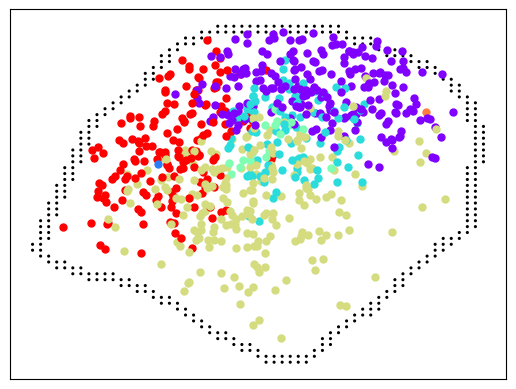

In [68]:
import mpl_toolkits.mplot3d

fig = plt.figure()

outline_mask2d1 = get_brain_outline2d(target_mask, axis=1, v=1)
o_indices1 = np.where(outline_mask2d1)

X=dfp['soma_z']
Y=dfp['soma_y']
Z=dfp['soma_x']

ax = plt.subplot(111)
plt.scatter(o_indices1[1], o_indices1[0], s=5, c='black', alpha=1.0, edgecolors='none')
for i in range(dfp.shape[0]):
    ax.scatter(Z[i],X[i],c=color_dict2[L[i]],s=25)
    plt.xticks([])
    plt.yticks([])

plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig1/VPM_cluster.png",dpi=100)

In [23]:
vpm_file_path = "/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/output_full_r671/parc_region733.nrrd"
vpm_parc = load_image(vpm_file_path)
np.max(vpm_parc)

4

In [58]:
nzcoords = vpm_parc.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
colorize_vpm = random_colorize(nzcoords_t,vpm_parc[nzcoords],vpm_parc.shape,np.max(vpm_parc))

In [25]:
zmin, ymin, xmin = nzcoords_t.min(axis=0)
zmax, ymax, xmax = nzcoords_t.max(axis=0)
zmin, ymin, xmin, zmax, ymax, xmax

(269, 135, 255, 324, 196, 309)

In [26]:
np.max(vpm_parc)

4

In [28]:
import matplotlib.pyplot as plt

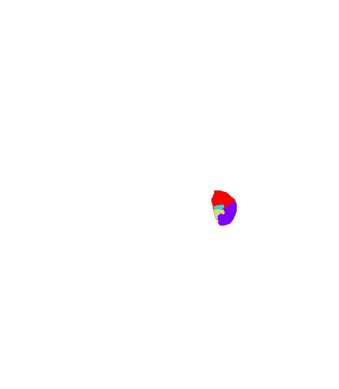

In [69]:
plt.figure()
plt.imshow(np.transpose(colorize_vpm[:,160,:],axes=[1,0,2]))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
out_path = '/Users/krystal/Desktop/project/microenvironment/figs/Fig1/VPM.png'
plt.savefig(out_path,dpi=500)

In [70]:
tree_json_path = '/Users/krystal/Desktop/project/tree_yzx.json'
with open(tree_json_path, 'r') as file:
    tree_json = json.load(file)

In [71]:
tree_json

[{'acronym': 'root',
  'rgb_triplet': [255, 255, 255],
  'graph_id': 1,
  'graph_order': 0,
  'id': 997,
  'name': 'root',
  'structure_id_path': [997],
  'structure_set_ids': [691663206]},
 {'acronym': 'grey',
  'rgb_triplet': [191, 218, 227],
  'graph_id': 1,
  'graph_order': 1,
  'id': 8,
  'name': 'Basic cell groups and regions',
  'structure_id_path': [997, 8],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892]},
 {'acronym': 'CH',
  'rgb_triplet': [176, 240, 255],
  'graph_id': 1,
  'graph_order': 2,
  'id': 567,
  'name': 'Cerebrum',
  'structure_id_path': [997, 8, 567],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892]},
 {'acronym': 'CTX',
  'rgb_triplet': [176, 255, 184],
  'graph_id': 1,
  'graph_order': 3,
  'id': 688,
  'name': 'Cerebral cortex',
  'structure_id_path': [997, 8, 567, 688],
  'structure_set_ids': [112905828,
   691663206,
   12,
   18452

In [72]:
brain_to_id = {}
brain_id_path = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    acronym = tree_json[i]['acronym']
    p = tree_json[i]['structure_id_path']
    if bid not in brain_to_id:
        brain_to_id[bid] = acronym
    if bid not in brain_id_path:
        brain_id_path[bid] = p        

In [73]:
count_times = {}
for k,v in brain_id_path.items():
    tmp_path = v
    if k in REGION671:
        for i in tmp_path:
            if i in REGION671:
                if i not in count_times:
                    count_times[i] = 0
                else:
                    count_times[i] += 1

In [74]:
len(count_times)

671

In [75]:
count_times2 = {}
for i in REGION671:
    tmp_path = brain_id_path[i]
    for j in tmp_path:
        if j in REGION671:
            if j not in count_times2:
                count_times2[j] = 0
            else:
                count_times2[j] += 1

In [76]:
region_namelist = []
region_idlist = []
for k,v in count_times2.items():
    if v > 0:
        region_namelist.append(brain_to_id[k])
        region_idlist.append(k)

In [77]:
len(region_idlist)

29

In [224]:
max_sub_R = 0
max_sub_name = ''
for i in REGION671:
    if count_times[i]> max_sub_R:
        max_sub_R = count_times[i]
        max_sub_name = brain_to_id[i]

In [225]:
max_sub_R,max_sub_name

(670, 'root')

In [247]:
# major brain structure: CTX,TH,CNU,MB,HB,CB,HY
# id: 688,549,623,313,1065,512,1097
major_BS = [688,549,623,313,1065,512,1097]
count_major = [0 for i in range(len(major_BS))]
for i in REGION671:
    tmp_p = brain_id_path[i]
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            count_major[j] += 1
        

In [248]:
count_major

[295, 51, 27, 60, 77, 21, 50]

In [232]:
np.sum(count_major)

581

In [78]:
full_mask_path = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/intermediate_data/parc_r671_full.nrrd'
full_parc_mask = load_image(full_mask_path)

In [79]:
np.max(full_parc_mask)

1483

In [80]:
final_result_folder = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/output_full_r671'
image_files = glob.glob(final_result_folder+"/*")
used_ids = []
parc_count = {}
for f in image_files:
    f_name = os.path.basename(f)
    region_id = int(f_name.split(".")[0].split("parc_region")[1])
    image_tmp = load_image(f)
    n = np.max(image_tmp)
    parc_count[region_id] = n

In [96]:
totalR = 0
for i in REGION671:
    if i in parc_count:
        totalR += parc_count[i]
    else:
        totalR += 1

In [97]:
totalR

1572

In [85]:
major_BS = [688,549,623,313,1065,512,1097]
count_major = [0 for i in range(len(major_BS))]
for i in REGION671:
    tmp_p = brain_id_path[i]
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            count_major[j] += 1

In [86]:
count_major

[295, 51, 27, 60, 77, 21, 50]

In [87]:
count_major2 = [0 for i in range(len(major_BS))]
for i in REGION671:
    tmp_p = brain_id_path[i]
    if i in parc_count:
        plus = parc_count[i]
    else:
        plus = 1
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            count_major2[j] += plus      

In [88]:
count_major2

[751, 107, 135, 124, 161, 117, 84]

In [89]:
num_subR = 0
for i in REGION671:
    if i in parc_count:
        if parc_count[i] > 1:
            num_subR += 1

In [90]:
num_subR

220

In [91]:
df

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,pc12_me,pc13_me,pca_vr1_me,pca_vr2_me,pca_vr3_me,pca_feat1,pca_feat2,pca_feat3,region_name_r671,region_id_r671
10012_10978_7039,167,1017.8800,3,8,17,10,136.3750,113.975,138.9750,2.95928,...,0.284699,-0.636521,-0.547229,0.852097,0.103385,-0.835007,-2.127040,1.181976,ENTm5,727
10033_6960_5060,333,2827.4300,5,17,37,21,151.9250,165.225,193.6250,4.07808,...,-0.181951,-1.048770,-1.686488,0.495724,2.137492,3.156393,-2.719096,-0.443740,VISC2/3,1106
10047_11078_6926,223,1520.5300,3,10,21,12,106.8750,123.725,159.2250,3.45740,...,0.657077,-1.448032,0.531264,-0.467558,-0.407453,-0.992632,-1.404741,0.445671,ENTm6,743
10051_10842_7076,322,1809.5600,4,14,31,18,147.2250,167.825,143.9250,2.85155,...,0.590164,0.161788,-0.545198,0.579725,0.332841,-0.842937,-2.380767,1.211568,ENTm5,727
10067_11132_3158,220,1809.5600,2,12,24,13,137.7750,191.800,113.9000,4.33091,...,0.521240,-0.121713,0.680201,0.238475,-1.236428,-1.332363,-0.999405,-0.650435,CLA,583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17731_28751_6261,120,201.0620,2,6,12,7,73.1499,186.775,62.8252,6.64500,...,-0.052143,0.199861,0.587692,-1.352042,0.262060,0.127304,1.377574,1.355647,ENTl3,52
18176_24155_6193,161,3216.9900,3,6,13,8,90.6748,184.275,180.3750,6.43106,...,2.135186,-1.424774,0.365560,0.151575,-0.684484,-2.927304,-5.076733,3.984308,PA,780
5739_15373_6339,433,2123.7200,4,20,42,23,124.6990,141.125,176.1500,4.58383,...,0.082809,-1.130637,-0.623362,-0.028224,0.970590,1.932565,-0.106341,1.427491,RSPagl5,774
9571_7846_6146,569,4071.5000,5,25,53,29,139.5750,189.450,143.6000,5.02566,...,-0.864035,-0.525231,-0.946358,1.292044,0.333765,2.587728,-1.381591,0.931290,AUDd6a,156


In [94]:
num_with_subR = 0
for i in REGION671:
    if i in parc_count:
        if parc_count[i] > 1:
            num_with_subR += parc_count[i]
        else:
            l = len(df[df['region_id_r671']==i])
            if l > 0:
                num_with_subR += 1
    else:
        l = len(df[df['region_id_r671']==i])
        if l > 0:
            num_with_subR += 1

In [95]:
num_with_subR

1484

In [98]:
final_ccf_path = '/Users/krystal/Desktop/project/pylib-main/anatomy/resources/annotation_25.nrrd'
ccf_mask = load_image(final_ccf_path)

In [99]:
anno_rgba = np.zeros(list(ccf_mask.shape)+[4],dtype=np.uint8)

In [101]:
color_record_ccf = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    if bid in REGION671:
        color_record_ccf[bid] = tree_json[i]['rgb_triplet']

In [102]:
for i in np.unique(ccf_mask):
    cur_color = []
    if i==0:
        continue
    else:
        cur_color = np.array(color_record_ccf[i]+[255])
        anno_rgba[ccf_mask==i] = cur_color

In [103]:
anno_rgba.shape

(456, 320, 528, 4)

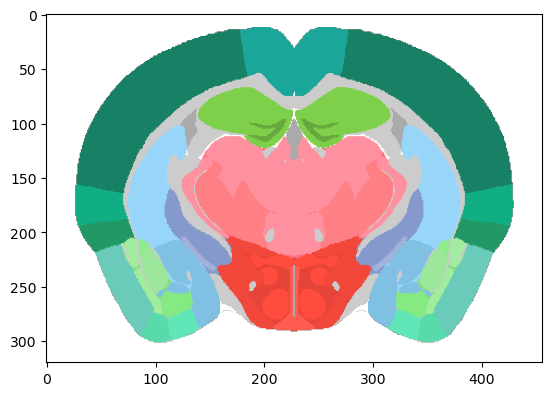

In [104]:
plt.figure()
plt.imshow(np.transpose(anno_rgba[:,:,264],axes=[1,0,2]))
out_path = '/Users/krystal/Desktop/project/microenvironment/stereo_img/out_slice_'+str(int(i))+'_m.png'
#plt.savefig(out_path)

In [105]:
parc_mask = load_image("/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/intermediate_data/parc_r671_full.nrrd")

In [106]:
parc_mask_copy = parc_mask.copy()
parc_mask_copy2 = parc_mask_copy[::-1,:,:]
parc_mask_copy3 = parc_mask_copy + parc_mask_copy2

In [107]:
parc_mask_copy.shape

(456, 320, 528)

In [114]:
mask = parc_mask_copy3

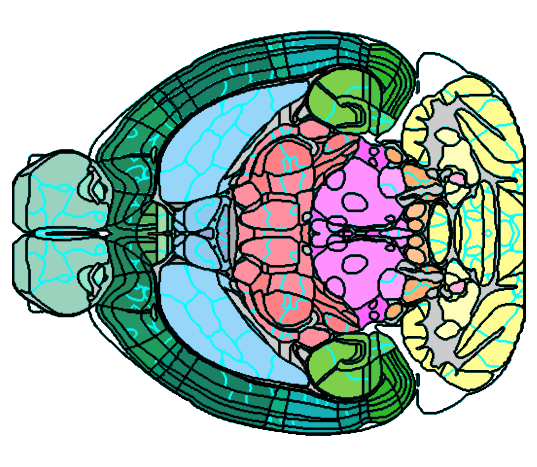

In [116]:
axis_id = 1
boundary_mask1 = get_section_boundary(ccf_mask,axis=axis_id,v=1,c=None)
sh1, sw1 = boundary_mask1.shape[:2]
fig, ax = plt.subplots(dpi=120)
brain_mask2d1 = get_brain_mask2d(ccf_mask, axis=axis_id, v=1)
im = np.ones((sh1, sw1, 4), dtype=np.uint8) * 255
im[~brain_mask2d1] = 0#1

b_indices1 = np.where(boundary_mask1)
# intra-brain regions

outline_mask2d1 = get_brain_outline2d(ccf_mask, axis=axis_id, v=1)
o_indices1 = np.where(outline_mask2d1)

boundary_mask = get_section_boundary(mask,axis=axis_id,v=1,c=None)
sh, sw = boundary_mask.shape[:2]
brain_mask2d = get_brain_mask2d(mask, axis=axis_id, v=1)
im = np.ones((sh, sw, 4), dtype=np.uint8) * 255
im[~brain_mask2d] = 0#1

ax.imshow(anno_rgba[:,160,:])
#ax.imshow(np.transpose(anno_rgba[228,:,:],axes=[0,1,2]))
#ax.imshow(np.transpose(anno_rgba[:,:,264],axes=[0,1,2]))

b_indices = np.where(boundary_mask)
ax.scatter(b_indices[1], b_indices[0], s=0.8, c='cyan', alpha=1.0, edgecolors='none')
# intra-brain regions

outline_mask2d = get_brain_outline2d(mask, axis=axis_id, v=1)
o_indices = np.where(outline_mask2d)
ax.scatter(o_indices[1], o_indices[0], s=1, c='cyan', alpha=1.0, edgecolors='none')

ax.scatter(b_indices1[1], b_indices1[0], s=1, c='black', alpha=1.0, edgecolors='none')
ax.scatter(o_indices1[1], o_indices1[0], s=1, c='black', alpha=1.0, edgecolors='none')

plt.axis('off')
out_path = '/Users/krystal/Desktop/project/microenvironment/figs/Fig1/brain.png'
plt.savefig(out_path,dpi=100)